In [1]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [2]:
fig_dir = Path("../runs/LSTM_MLP_Q/_figures")
exp_dict = {
    'All Data': Path("../runs/LSTM_MLP_Q/all_data_20241107_153038"),
    'SSC only': Path("../runs/LSTM_MLP_Q/ssc_only_20241110_173843"),
    'SSF only': Path("../runs/LSTM_MLP_Q/ssf_only_20241110_173906")
}

exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
predict_results = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        
        # for feat in ['usgs_q']:
        for feat in basin_m.columns.get_level_values('Feature').unique():
            lt10 = basin_m[feat]['num_obs'] < 10
            basin_m.loc[lt10, feat] = np.nan
        
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)
        
    # with open(exp_dir / "predict_data.pkl", 'rb') as f:
    #     r, _, _ = pickle.load(f)
    #     predict_results.append(r)

results = [results[0], pd.concat(results[1:],axis=1)]
basin_metrics = [basin_metrics[0], pd.concat(basin_metrics[1:],axis=1)]
tmp = {}
[tmp.update(m) for m in bulk_metrics[1:]]
bulk_metrics = [bulk_metrics[0], tmp]


# Define colors and styles
all_color = '#d95f02'
spc_color = 'tab:blue'

line_styles = [
    (all_color,'-'),
    (spc_color,'-'),
]

# Create custom legend elements
legend_elements = [
    mp.lines.Line2D([0], [0], color=all_color, lw=2, label='Multitask'),
    mp.lines.Line2D([0], [0], color=spc_color, lw=2, label='Specialized'),
]           

        
fig_dir.mkdir(exist_ok=True, parents=True)

In [3]:
basin_metrics[0]['flux']['RB'].quantile([0.25, 0.75])

0.25   -24.975334
0.75     1.615298
Name: RB, dtype: object

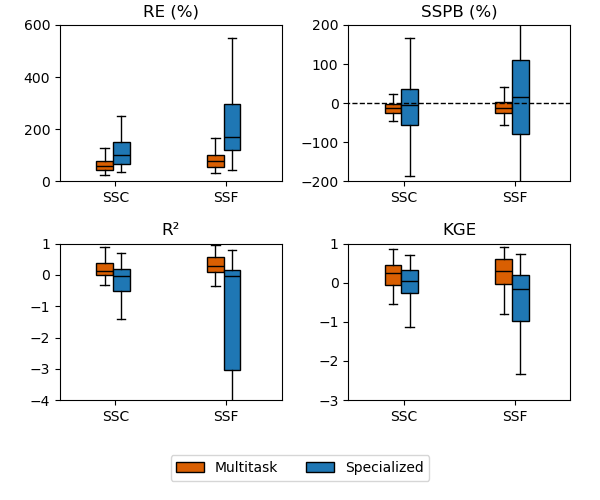

In [13]:
plt.close('all')

num_models = len(results)
target_variables = ['ssc','flux']
num_targets = len(target_variables)

colors = [t[0] for t in line_styles]
lines = [t[1] for t in line_styles]
face_colors = [c + ('' if l=='-' else '50') for c, l in zip(colors,lines)]

# Box width and spacing adjustments
box_width = 0.15
offset = box_width * (num_models / 2)

metric_names = {'RE':'RE (%)', 
                'RB':'SSPB (%)',
                'R2': 'R²',
                'KGE': 'KGE'}

n_metrics = len(metric_names)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
axes= axes.flatten()

for ax, (mkey, mname) in zip(axes, metric_names.items()):
    for j, var in enumerate(target_variables):
        positions = np.array([j + (i - num_models / 2 + 0.35) * box_width for i in range(num_models)])
        
        box_data = [np.array(m.get((var,mkey),np.nan), dtype=float) for m in basin_metrics]
        box_data = [x[~np.isnan(x)] for x in box_data]
        box = ax.boxplot(box_data, positions=positions, widths=box_width,
                         patch_artist=True, medianprops={'color':'black'}, showfliers=False)
        
        for patch, face_color in zip(box['boxes'], face_colors):
            patch.set_facecolor(face_color)
            
        ax.set_title(mname)

    ax.set_xticks(np.arange(num_targets))
    ax.set_xticklabels(['SSC','SSF'])
    ax.set_xlim([-0.5, 1.5])
    

# Modify axes, legends, etc. as needed
axes[0].set_ylim([0, 600])
# axes[0].set_yscale('log')

axes[1].plot([-1, 3], [0, 0], 'k', linestyle='--', linewidth=1, zorder=10)
axes[1].set_ylim([-200, 200])
# axes[1].set_yscale('symlog')

# axes[2].plot([-1, 3], [0, 0], 'k', linestyle='--', linewidth=1, zorder=10)
axes[2].set_ylim([-4, 1])

axes[3].set_ylim([-3, 1])


# Create custom legend elements
box_legend = [
    mp.patches.Rectangle((0, 0), 1, 1, color=all_color, ec='black', label='Multitask'),
    mp.patches.Rectangle((0, 0), 1, 1, color=spc_color, ec='black', label='Specialized')
]

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.4)
fig.legend(handles=box_legend, loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=2)

plt.show()

fig.savefig(fig_dir / f"multitask_basin_boxplots_zoom.png", dpi=300)


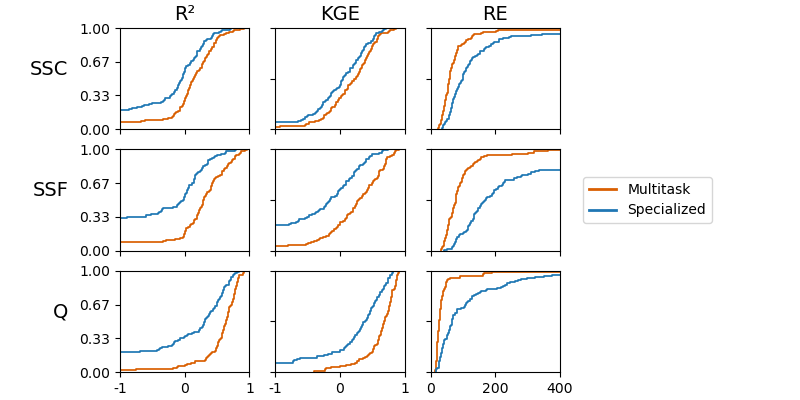

In [10]:
plt.close('all')

metric_args = {
    'R2':{'range':[-1,1]},
    'KGE':{'range':[-1,1]},
    'RE': {'range':[0,400]}
    }

feature_labels = ['SSC', 'SSF', 'Q']
features = ['ssc', 'flux', 'usgs_q']
nRows = len(features)
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(8, 4))

for feature, axes_row in zip(features, axes):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m, (c, s) in zip(basin_metrics, line_styles):
            if (feature, metric) not in m:
                continue
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            
            if 'bias' in metric.lower():
                x = np.abs(x)
                
            ax.ecdf(x, color=c, linestyle=s, linewidth=1.25)
        
        # ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
# Top Axes
for metric, ax in zip(['R²','KGE','RE'], axes[0,:]):
    ax.set_title(metric, fontsize=14)
    
# Bottom Axes
for ax in axes[-1,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels([int(label) for label in np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)])
    
# Left Axes
for label, ax in zip(feature_labels, axes[:,0]):
    ax.set_ylabel(label, rotation=0, ha='right', fontsize=14, labelpad=8)
    ax.set_yticks(np.linspace(0, 1, 4))
    ax.set_yticklabels([f"{lab:0.2f}" for lab in np.linspace(0, 1, 4)])
    

# Adjust spacing to make room for the legend
plt.subplots_adjust(top=0.93, bottom=0.07, left=0.15, right=0.7)

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.72, 0.5))


# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / "multitask_ablation_cdfs.png",  dpi=300)

In [236]:
avg_dt = results[0]['dt']['landsat'].groupby(level='basin').mean().values
RE_change = (basin_metrics[0]['flux']['RE']- basin_metrics[2]['flux']['RE']).values.astype(float)

In [238]:
results[0]

Type                     obs                           pred               \
Feature                  ssc flux       usgs_q          ssc         flux   
basin         date                                                         
USGS-08049500 2000-05-30 NaN  NaN     7.362381    68.011223    49.591797   
USGS-03234500 1984-05-10 NaN  NaN   239.843658   149.774155  8227.149414   
USGS-05330000 1983-06-10 NaN  NaN   156.875290   234.059418  5224.394043   
USGS-03234500 1995-01-11 NaN  NaN    32.281208     5.365226     8.244576   
USGS-03085000 1992-09-08 NaN  NaN   102.223808    18.721369   299.417511   
...                       ..  ...          ...          ...          ...   
USGS-06882000 2002-02-05 NaN  NaN     7.362381    26.100765     9.324088   
USGS-09371010 2012-08-18 NaN  NaN    14.300009  1190.486328  1591.156006   
USGS-07308500 1996-08-29 NaN  NaN   478.554657   147.422501    92.162560   
USGS-05526000 1987-03-18 NaN  NaN    22.653477    39.968819   457.526672   
USGS-05586100 2009-12-07 NaN  NaN  1206.297852    45.175453  2211.854004   

Type                                   dt          
Feature                       usgs_q era5 landsat  
basin         date                                 
USGS-08049500 2000-05-30    7.744249    0       7  
USGS-03234500 1984-05-10  477.745728    0     366  
USGS-05330000 1983-06-10  229.264069    0     366  
USGS-03234500 1995-01-11   13.978035    0      65  
USGS-03085000 1992-09-08  173.436279    0       8  
...                              ...  ...     ...  
USGS-06882000 2002-02-05    3.555387    0      16  
USGS-09371010 2012-08-18   16.138575    0      47  
USGS-07308500 1996-08-29    4.564307    0      22  
USGS-05526000 1987-03-18   99.247955    0      36  
USGS-05586100 2009-12-07  449.527008    0       2  

[1135552 rows x 8 columns]

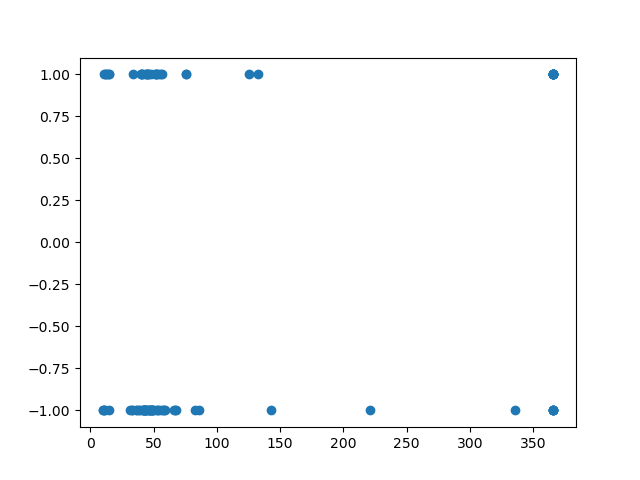

In [237]:
plt.close('all')
plt.scatter(avg_dt,np.sign(RE_change))

In [235]:
basin_metrics[0]['flux']['RE'].values.astype(float)

array([  62.96199417,           nan,   73.32421875,  139.93380737,
        177.04624939,  170.96815491,  180.85835266, 1025.52111816,
                 nan,           nan,           nan,           nan,
         93.99062347,           nan,           nan,   77.30312347,
        425.04434204,           nan,  150.94927979,           nan,
        133.25186157,  127.1999588 ,   75.9888382 ,  149.82054138,
         80.34044647,  164.92471313,           nan,  122.61740875,
                 nan,  183.05702209,  271.83856201,  114.15602875,
        196.31826782,           nan,           nan,   30.68987083,
        116.59645844,           nan,           nan,           nan,
         91.77459717,  200.76577759,  125.0831604 ,  266.91433716,
       2520.62255859,   87.91965485,  100.08368683,  165.50497437,
                 nan,           nan,           nan,           nan,
        560.59997559,   95.95396423,  118.96889496,  147.00648499,
                 nan,  175.37486267,           nan,  191.11340

In [223]:
np.sign(RE_change)

TypeError: unorderable types for comparison

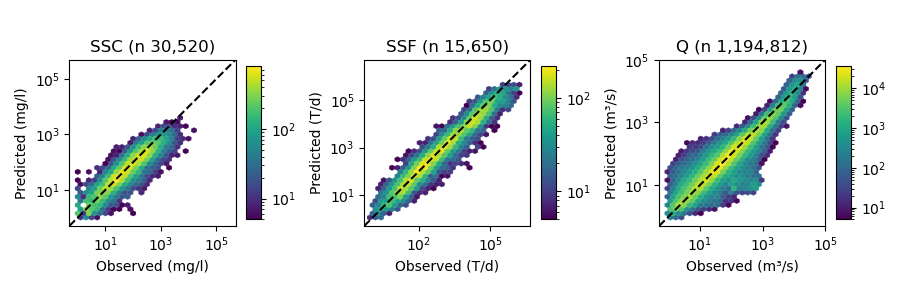

In [11]:
def hexbin_1to1(ax, x, y, target, target_label, max_val, unit):
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]

    min_val = 5E-1
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)

    hb = ax.hexbin(x, y, gridsize=(30,20), bins='log', mincnt=5,
                linewidth=0.2,
                extent=(log_min, log_max, log_min, log_max),
                xscale='log', yscale='log')
    plt.colorbar(hb, shrink=0.6, aspect=10, anchor=(0,0.5))

    # Add a 1:1 line over the min and max of x and y
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # Setting axes to be square and equal range
    ax.axis('square')
    ax.set_xlim(min_val, max_lim)
    ax.set_ylim(min_val, max_lim)
    ax.set_title(f"{target_label} (n {len(x):,})")
    ax.set_xlabel(f'Observed ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')

    

targets = ['ssc','flux','usgs_q']
target_labels = ['SSC', 'SSF', 'Q']
units = ['mg/l', 'T/d', 'm³/s']
max_lims = [5E5, 5E6, 1E5]

fig, axes = plt.subplots(1,len(targets), figsize=(len(targets)*3, 3))

idx_plot = 0
axes = [axes] if len(targets)==1 else axes        
for target, target_label, unit, max_lim, ax in zip(targets, target_labels, units, max_lims, axes):
    dt_mask = results[idx_plot]['dt'].max(axis=1) >= 0
    x = results[idx_plot]['obs'][target]
    y = results[idx_plot]['pred'][target]
    hexbin_1to1(ax, x[dt_mask], y[dt_mask], target, target_label, max_lim, unit)

plt.tight_layout()

# fig.savefig(fig_dir / f"bulk_scatterplots.png", dpi=300)

In [11]:
bulk_metrics[0]

{'ssc': {'num_obs': np.int64(30520),
  'R2': 0.09180808067321777,
  'MAPE': np.float64(72.00913953866711),
  'nBias': np.float32(-15.688385),
  'RE': np.float32(66.13759),
  'RB': np.float32(-18.607628),
  'qRE': array([ 27.10661333,  66.13758491, 142.96229533]),
  'qnBias': array([-47.80155271, -15.68838507,  38.54626939]),
  'MAE': np.float32(175.42253),
  'RMSE': np.float32(1216.1055),
  'rRMSE': np.float32(1066.6625),
  'KGE': np.float64(-0.16759659075430489),
  'NSE': np.float32(-40.171993),
  'Agreement': np.float32(0.122047186)},
 'flux': {'num_obs': np.int64(15650),
  'R2': 0.4080323576927185,
  'MAPE': np.float64(128.8484394404704),
  'nBias': np.float32(-18.114208),
  'RE': np.float32(94.80097),
  'RB': np.float32(-22.121311),
  'qRE': array([ 37.03482432,  94.80097064, 228.14133682]),
  'qnBias': array([-57.70207942, -18.11420992,  57.90017545]),
  'MAE': np.float32(22269.043),
  'RMSE': np.float32(112713.72),
  'rRMSE': np.float32(559.9107),
  'KGE': np.float64(0.2266915542

In [60]:
import sklearn.metrics as skm

def get_log_r2(df):
    x = df['obs']['flux']
    y = df['pred']['flux']
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]
    
    if len(x) > 10:
        return skm.r2_score(np.log10(x),np.log10(y))
    else:
        return np.nan

r2 = results[0].groupby(level='basin').apply(get_log_r2)
r2.median()

np.float64(0.32172825932502747)

In [42]:
basin_metrics[0]['flux']

Metric,num_obs,R2,MAPE,nBias,RE,RB,qRE,qnBias,MAE,RMSE,rRMSE,KGE,NSE,Agreement
USGS-01049265,86,0.811611,191.853237,43.293034,70.563576,43.292629,"[26.968622995962033, 70.56358788264328, 200.40...","[-7.384832203388214, 43.29303503036499, 162.52...",231.857101,632.840454,154.034393,0.667433,0.594755,0.871439
USGS-01198550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USGS-01443000,18,0.991146,109.723078,5.073632,89.376129,5.045068,"[13.764775615543524, 89.37613882823783, 195.09...","[-15.642365626990795, 5.07363136857748, 133.69...",54.566566,93.799728,24.392275,0.933568,0.992,0.995798
USGS-01474500,82,0.100259,179.029688,62.378849,137.885925,62.378681,"[62.262144450595216, 137.8859063490836, 418.72...","[-34.63496342301369, 62.37884759902954, 193.34...",1708.3927,7713.799316,2565.308838,-0.252749,-105.37999,0.137614
USGS-01567000,214,-0.70161,263.661005,99.849228,180.250305,99.843147,"[83.13324443700347, 180.25029510299328, 435.39...","[-23.19689318537712, 99.84923005104065, 325.25...",6381.231445,18723.158203,262.324463,0.056412,0.038619,0.394298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-13342500,127,0.047707,102.935524,-71.839584,266.074707,-255.108353,"[101.55105549972791, 266.0747146392033, 561.85...","[-84.15361642837524, -71.83958292007446, -23.5...",1898.69519,5946.240723,1361.562012,-0.258508,-42.22345,0.146433
USGS-14211720,295,0.625657,99.127312,-56.381966,184.43808,-129.26297,"[70.3103687942906, 184.43812150409556, 519.282...","[-81.77861869335175, -56.381964683532715, -8.8...",2596.579346,9946.685547,320.376434,0.475424,-0.052821,0.725048
USGS-14321000,28,0.317664,127.419214,37.417877,113.413383,37.383236,"[15.972316173826684, 113.4133975188615, 257.25...","[7.890508323907852, 37.41787672042847, 171.160...",262.763153,765.986389,275.646637,0.249943,-2.167223,0.449368
USGS-383103106594200,52,0.09397,78.701787,-59.028118,163.508057,-144.247849,"[64.98030412744068, 163.50807412544373, 448.84...","[-81.04019910097122, -59.02811884880066, -1.44...",248.654709,884.935242,908.083801,-0.177319,-17.480438,0.172735


In [ ]:
import evaluate
evaluate.get_all_metrics(results[0][dt_mask])

In [121]:
cfg = {'step_kwargs':{'aaa':1, 'bbb':2}}
cfg.get('target_weights',{}).get('ssc', 1)

1

In [ ]:
matchups

In [ ]:
plt.close('all')
sites[metric].hist()

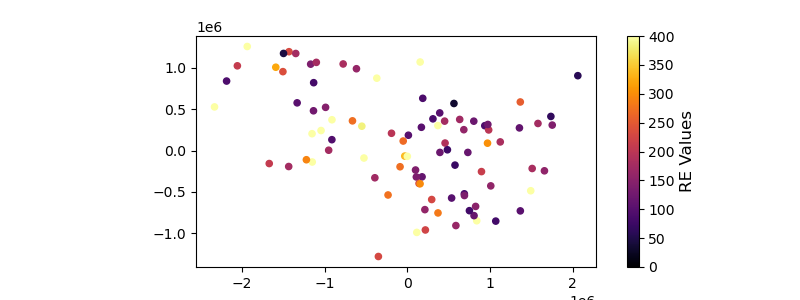

In [35]:
from matplotlib.colors import Normalize


sites = pd.read_csv('/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/preprocess/hydrography_matchups.csv',index_col='wqp_id')
geom = gpd.GeoSeries.from_wkt(sites.geometry)
sites = gpd.GeoDataFrame(sites, geometry = geom)

var = 'flux'
metric = 'RE'

sites = sites.merge(basin_metrics[0][var][metric], left_index=True, right_index=True)
sites[metric] = sites[metric].astype(float)

plt.close('all')

# Create a plot with GeoPandas
fig, ax = plt.subplots(figsize=(8, 3))

# Define the normalization from -1 to 1
# norm = Normalize(vmin=-1, vmax=1)
# cmap = 'RdYlBu'

norm = Normalize(vmin=0, vmax=400)
cmap = 'inferno'

# Plot the data, specifying 'KGE' as the column, and applying the colormap and normalization
sites.plot(column=metric, cmap=cmap, norm=norm, markersize=20, ax=ax)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to avoid warnings
cbar = fig.colorbar(sm, ax=ax)

# Optional: Set colorbar label
cbar.set_label(f'{metric} Values', fontsize=12)

plt.show()